In [138]:
import torch
import requests
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
torch.manual_seed(1337)

In [ ]:
text = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").text

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 100 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(vocab_size)
''.join(chars)

65


"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [ ]:
# create a mapping from characters to integers

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # first 100 characters

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [ ]:
# Create train and validation split
# 90% train, 10% val

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [132]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.embedding_table(idx)
        B, T, C = logits.shape
        loss = None
        if targets != None:
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, num_tokens):
        for _ in range(num_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, next_idx], dim=1)
        return idx

    def predict(self, num_tokens):
        x = torch.zeros((1, 1), dtype=torch.long)
        y = self.generate(x, num_tokens)
        print(decode(y[0].tolist()))

In [133]:
# forward pass over a batch

m = BigramLanguageModel()
logits, loss = m(xb, yb)
logits.shape, loss.item()

(torch.Size([32, 65]), 4.325235366821289)

In [134]:
# generation of tokens

m.predict(num_tokens=500)


-s$gTBx$vfO'NvdtNVeXu F: jYd&O?FSpLfZKhqPOmGPz &QjzDJnB$JbGAJDFQc$WT!ubSPj&FSgqHwqCjqpjfZP!qluW&c3tNDOnA'$.tSpvHPQ!i,ey3uc
XryYckGDAAI!kLiPnpdgcz
rQRpI-e&JQ
vlsHcfpiofV,HGLCclsTAOpc,lo3Qfh&LfDw
$GZ YnHPh:eWKRUYojuqG-dGB
pn-NaeXjsHPBKwUIeCirDCiekvq'IBvve!si,HWK.F:TI.UtRk Th;JVF$Atd!gCiV--uubDsTIR EtWhMQUftLNvpXSASP.tf.hEFFSdG;fMzNv?oQCxE.3tpaqSRbF'Fl;eAccI;yzRGqOXcTKMh?FzLcMiJd&RDgoTRAO DKUJB!jE'UMh':bPmAI;gr.hVPLgZsYOGVIG,:bGDj?ET
XJkaM,HlxNc3fVclQEtJkKWpZd$ &YgPOr&URWEFiaOh&OVcctIs;T'hvl-O?kVCo


Sampling process from the model

- first we give the input as (B, T) as the C is 1 i.e. idx
- pass it through the embedding table to get embeddings of shape B, T, C
- eliminate the 1st dimension T because the model is bigram, from the inputs and targets
- the output takes shape B\*T, C
- index the last logits during the generation as we are not interested in the complete context in the bigram language model case
- take softmax and multinomially distributed sampling to sample the next character in sequence
- append the new character index into the existing context and truncate it from behind to maintain the block size and again sample from the model in an auto regressive manner


In [135]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [136]:
training_loss = []

for step in range(100001):

    xb, yb = get_batch('train')

    logits, loss = m(xb, yb) # forward pass
    optimizer.zero_grad()
    loss.backward() # backward pass, calculating gradients
    optimizer.step() # weights update using gradients

    training_loss.append(loss.item())

    if step % 10000 == 0:
        print(step, loss.item())

0 4.743443965911865
10000 2.1603057384490967
20000 2.632437229156494
30000 2.3771979808807373
40000 2.3128786087036133
50000 2.189937114715576
60000 2.712397813796997
70000 2.6763293743133545
80000 2.396946668624878
90000 2.528028726577759
100000 2.4879868030548096


In [141]:
a = [1, 2, 3, 4, 5]
a[:-1]

[1, 2, 3, 4]

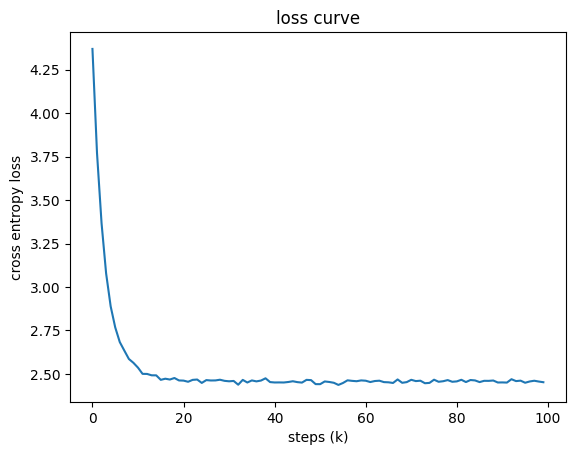

In [144]:
# loss curve

training_loss_avg = torch.tensor(training_loss[:-1]).view(-1, 1000).mean(1)
plt.plot(training_loss_avg)
plt.xlabel("steps (k)")
plt.ylabel("cross entropy loss")
plt.title("loss curve");

In [145]:
m.predict(500)


Jusslche; h co.
Coury?
BURor y, crd wo tarreror thindrariathitot.
Thathest
INOWe hin t 's ve PRINe f ses.

MBar, wiale
ANRDUThe pe best t e thtoufoucive.
LOFaishe thy s rigley, geanuk-
Whandestharyo wissad; aicouit, ply!
Hew k s teawithisshe amatos beat fepan cor nd CY heng Whonor as wichioroues?


Frer monmy ckichethtinectoury'ded e s,
Myo

Ageayothe d faloury t oram. co dathintha vessorik, silofeigar tongat mu ict-le norra the ow athe aketifest; t w brothenete ousald tle ppl bere overer,

Thel


The model is starting to follow the format of the input data. The model is learning. But the output is not great because of the model capacity (bigram).
